In [1]:
import numpy as np
import pandas as pd
import yaml
import os
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

In [2]:
TASKNUM=3
dms_indices = list(range(TASKNUM))

In [3]:
train_df = pd.read_csv("../bindinggym_offline/input/BindingGYM_AL.csv")
idx2name = {i: train_df.loc[i, 'DMS_id'] for i in range(TASKNUM)}

In [4]:
metric_labels={
 'spearman': r"Spearman's $\rho$",
 'recall': 'Top 1% Recall',
 'top_mean_1': 'TopMean@10',
}
model_types={'sequence': 'ESM2',
 'structure': 'ProteinMPNN',
 'ablang2': 'AbLang2',
 'ablang2_gp': 'GPR (AbLang2)',
}
model_types_l = ["sequence", "ablang2", "ablang2_gp"]

In [5]:
init_fold=1
kernel_type="rbf"
add_kernel = True

BASEPATH="outputs"
path_ablang="outputs_ablang"

def get_config_path(strategy, noise_level, dms_index, N, init_fold, model_type, totN = 600, use_dropout=False, base_path=BASEPATH, is_multi=False):
    Ninit=init_fold*N
    cycle_n = (totN-Ninit)//N
    assert (totN-Ninit)%N==0
    expname = strategy if not is_multi else f"{strategy}_hv"
    expname = f"{expname}_{noise_level:.1f}" if not use_dropout else f"{expname}_{noise_level:.1f}_do"
    tmp_path = f"{base_path}/{expname}/dms_{model_type}_{dms_index}_N-{N}_ini-{init_fold}"
    return tmp_path
def get_config_ablang(workdir, random_seed, strategy, noise_level, dms_index, N, init_fold, kernel_type, add_kernel, totN = 600, save=False, use_dropout=False, is_multi=False):
    Ninit=init_fold*N
    cycle_n = (totN-Ninit)//N
    assert (totN-Ninit)%N==0
    expname = strategy if not is_multi else f"{strategy}_hv"
    expname = f"{expname}_{noise_level:.1f}" if not use_dropout else f"{expname}_{noise_level:.1f}_do"
    
    tmp_path = f"{workdir}/{random_seed}/{expname}/dms_{dms_index}_N-{N}_ini-{init_fold}"
    return tmp_path


In [6]:
pool_metrics_df_merge = pd.read_csv("../results/bindinggym_offline/pool_metrics_df_merge.csv")
test_metrics_df_merge = pd.read_csv("../results/bindinggym_offline/test_metrics_df_merge.csv")


In [8]:
import json
with open("../results/bindinggym_offline/baseline_scores_metric_list.json", 'r') as f:
    baseline_scores_metric_list = json.load(f)

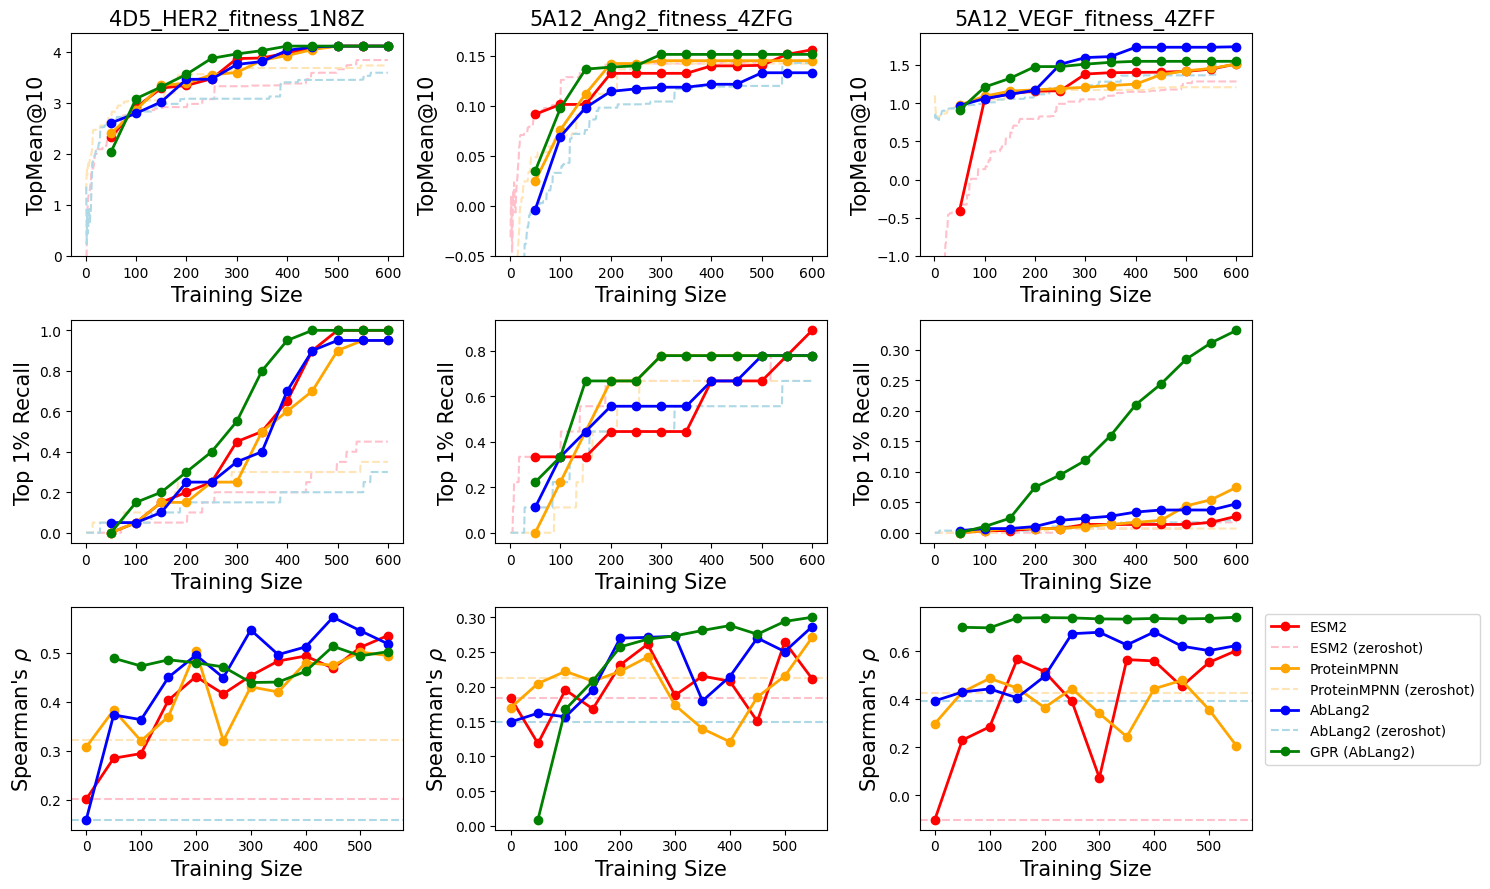

In [9]:
model_types_l2 = ['sequence', 'structure', 'ablang2', 'ablang2_gp']

def plot_dmsindex(Xdf, metric, dms_index, ax=None, show_test=False, figsize=(12, 5), fontsize=15):
    Xdf_sel = Xdf[Xdf["tmp_path"].isin(configs_dms_strat)]
    Xdf_sel = Xdf_sel[Xdf_sel["dms_index"]==dms_index]
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    colors = {
        "sequence": "red", "ablang2": "blue", "ablang2_gp": "green", "structure": "orange"
    }
    zero_colors = {
        "sequence": "pink", "ablang2": "lightblue", "structure": "moccasin"
    }
    zero_line_styles = {
        "sequence": "--", "ablang2": "--", "structure": "--"
    }

    for model_type in model_types_l2:
        data = Xdf_sel[Xdf_sel["model_type"] == model_type]
        
        for strategy in ["greedy"]:
            subset = data[data["strategy"] == strategy]
            mean_df = subset.groupby(["Training size"])[metric].mean()
            label = f"{model_types.get(model_type, model_type)}"
            ax.plot(mean_df.index, mean_df, label=label, marker="o", color=colors[model_type], linewidth=2)
            
        ax.set_xlabel("Training Size", fontsize=fontsize)
        ax.set_ylabel(metric_labels[metric], fontsize=fontsize)
        
        if baseline_scores_metric_list.get(metric):
            model_type2 = model_type if model_type !="structure" else "proteinmpnn"
            baseline_scores = baseline_scores_metric_list[metric][dms_index].get(model_type2, None)
            if show_test and baseline_scores is not None:
                if isinstance(baseline_scores, (int, float)):
                    ax.axhline(y=baseline_scores, color=zero_colors[model_type], linestyle=zero_line_styles[model_type], label=f"{model_types.get(model_type, model_type)} (zeroshot)",zorder=-10)
                else:
                    ax.plot(range(1,len(baseline_scores)+1), baseline_scores, color=zero_colors[model_type], linestyle=zero_line_styles[model_type], label=f"{model_types.get(model_type, model_type)} (zeroshot)",zorder=-10)
    plt.tight_layout()

noise_level=0
configs_dms_strat = []
N=50
for dms_index in range(TASKNUM):
    for strategy in ["greedy"]:
        for model_type in ["sequence", "structure", "ablang2"]:
            tmp_path =  get_config_path(strategy, 0, dms_index, N, init_fold, model_type, use_dropout=strategy!="greedy")
            configs_dms_strat.append(tmp_path)
        tmp_path =  get_config_ablang(path_ablang, 0, strategy, noise_level, dms_index, N, init_fold, kernel_type, add_kernel)
        configs_dms_strat.append(tmp_path)
dms2target = "4D5_HER2_fitness_1N8Z", "5A12_Ang2_fitness_4ZFG", "5A12_VEGF_fitness_4ZFF"

Xs = {"top_mean_1": pool_metrics_df_merge, "recall": pool_metrics_df_merge, "spearman": test_metrics_df_merge}
fig, axs = plt.subplots(3, TASKNUM, figsize=(15, 9))
for dms_index in range(TASKNUM):
    for i, metric in enumerate(["top_mean_1", "recall", "spearman"]):
        ax = axs[i, dms_index]
        if i == 0:
            ax.set_title(dms2target[dms_index], fontsize=15)
        plot_dmsindex(Xs[metric], metric, dms_index, show_test=True, ax=ax)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
axs[0][0].set_ylim(0)
axs[0][1].set_ylim(-0.05)
axs[0][2].set_ylim(-1)
plt.tight_layout()
plt.tight_layout()
plt.show()


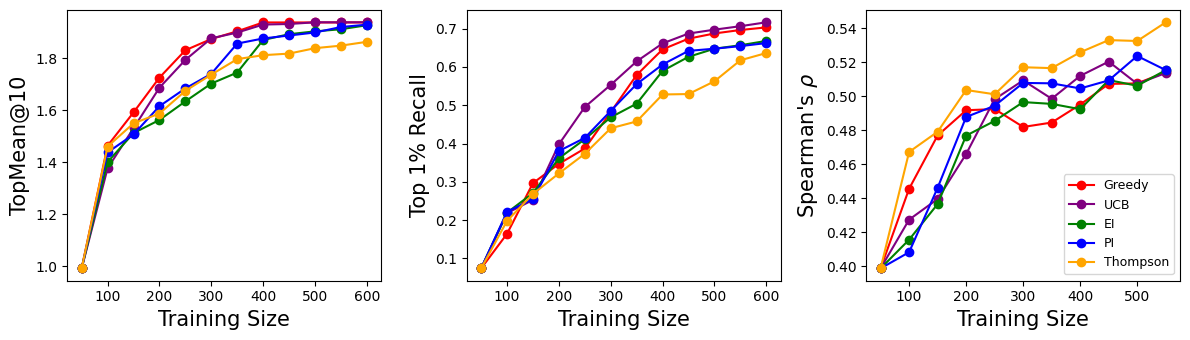

In [10]:
strategies_label = {
    "greedy": "Greedy",
    "ei": "EI",
    "pi": "PI",
    "ucb": "UCB",
    "thompson": "Thompson",
    "random": "Random"
}
def plot_strategy_comparison(Xdf1, Xdf2, metrics, show_test=False, figsize=(12, 5), fontsize=15):
    Xdf_sel1 = Xdf1[Xdf1["tmp_path"].isin(configs_model2_strat)]
    Xdf_sel2 = Xdf2[Xdf2["tmp_path"].isin(configs_model2_strat)]
    model_types_l = ["ablang2_gp"]
    fig, axes = plt.subplots(1,3,figsize=figsize)
    colors = {
        "random": "gray", "greedy": "red", "ei": "green",
        "pi": "blue", "ucb": "purple", "thompson": "orange"
    }
    line_styles = ["-", "--", ":", "-.", "-"]
    
    for ax_idx, metric in enumerate(metrics):
        Xdf_sel = Xdf_sel1 if metric in Xdf1.columns else Xdf_sel2
        data = Xdf_sel
        ax = axes[ax_idx]
        color_index = 0
        for strategy in ["greedy", "ucb", "ei", "pi", "thompson"]:
            subset = data[data["strategy"] == strategy]
            mean_df = subset.groupby(["Training size"])[metric].mean()
            ax.plot(mean_df.index, mean_df, label=strategies_label[strategy], marker="o", 
                   color=colors[strategy])
            color_index += 1
        
        ax.set_xlabel("Training Size", fontsize=fontsize)
        ax.set_ylabel(metric_labels[metric], fontsize=fontsize)

    ax.legend(fontsize=9)
    plt.tight_layout()


noise_level=0
configs_model2_strat = []
N=50
for dms_index in range(TASKNUM):
    for strategy in ["greedy", "pi", "ei", "ucb", "thompson"]:
        tmp_path =  get_config_ablang(path_ablang, 0, strategy, noise_level, dms_index, N, init_fold, kernel_type, add_kernel)
        configs_model2_strat.append(tmp_path)

plot_strategy_comparison(pool_metrics_df_merge, test_metrics_df_merge,  ["top_mean_1", "recall", "spearman"], figsize=(12, 3.5))


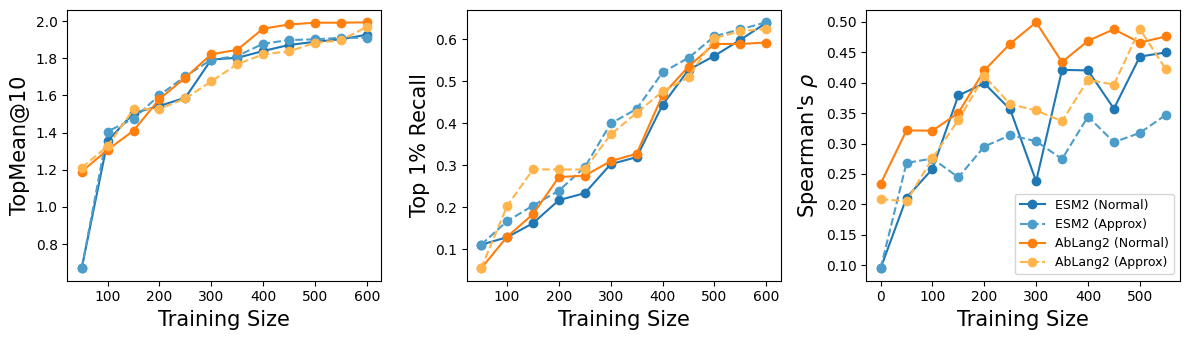

In [11]:
def plot_logit_comparison(Xdf1, Xdf2, metrics, show_test=False, figsize=(12, 5), fontsize=15):
    Xdf_sel1 = Xdf1[Xdf1["tmp_path"].isin(configs_model_logits)]
    Xdf_sel2 = Xdf2[Xdf2["tmp_path"].isin(configs_model_logits)]
    model_types_l = ["sequence", "ablang2"]
    fig, axes = plt.subplots(1,3,figsize=figsize)
    colors = ["#1f77b4", "#4c9dc9", "#ff7f0e", "#ffb54c"]  # Blue and orange pairs
    line_styles = ["-", "--", "-", "--"]
    
    for ax_idx, metric in enumerate(metrics):
        Xdf_sel = Xdf_sel1 if metric in Xdf1.columns else Xdf_sel2
        data = Xdf_sel
        ax = axes[ax_idx]
        color_index = 0
        for model_type in model_types_l:
            data_model = data[data["model_type"] == model_type]
            for logit_mode in [False, True]:
                subset = data_model[data_model["logit_mode"] == logit_mode]
                mean_df = subset.groupby(["Training size"])[metric].mean()
                label = model_types.get(model_type, model_type) + " "
                label += "(Approx)" if logit_mode else "(Normal)"
                ax.plot(mean_df.index, mean_df, label=label, marker="o", color=colors[color_index], linestyle=line_styles[color_index])
                color_index += 1
                
            ax.set_xlabel("Training Size", fontsize=fontsize)
            ax.set_ylabel(metric_labels[metric], fontsize=fontsize)
            
    ax.legend(fontsize=9)
    
    plt.tight_layout()


strategy="greedy"
noise_level=0
N=50
configs_model_logits = []
for dms_index in range(TASKNUM):
    for model_type in ["sequence", "ablang2"]:
        tmp_path = get_config_path(strategy, 0, dms_index, N, init_fold, model_type)
        configs_model_logits.append(tmp_path)
        tmp_path = get_config_path(strategy, noise_level, dms_index, N, init_fold, model_type, use_dropout=False, base_path="outputs_logits")
        configs_model_logits.append(tmp_path)

plot_logit_comparison(pool_metrics_df_merge, test_metrics_df_merge,  ["top_mean_1", "recall", "spearman"], figsize=(12, 3.5))


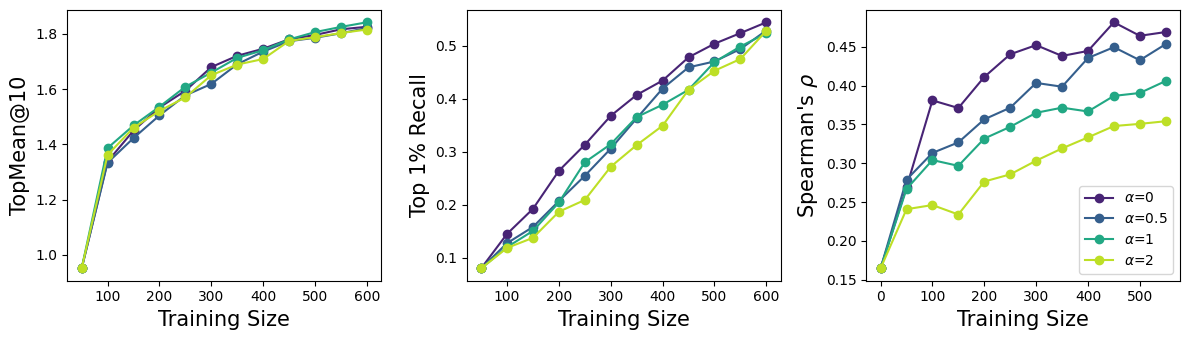

In [12]:
def plot_noise_comparison(Xdf1, Xdf2, metrics, show_test=False, figsize=(12, 5), fontsize=15):
    Xdf_sel1 = Xdf1[Xdf1["tmp_path"].isin(configs_model_noises)]
    Xdf_sel2 = Xdf2[Xdf2["tmp_path"].isin(configs_model_noises)]
    fig, axes = plt.subplots(1,3,figsize=figsize)
    colors = {
        0: plt.cm.viridis(0.1), 0.5: plt.cm.viridis(0.3), 1: plt.cm.viridis(0.6), 2: plt.cm.viridis(0.9)
    }
    # Get global min and max values for y-axis
    y_min = float('inf')
    y_max = float('-inf')
    for metric in metrics:
        Xdf_sel = Xdf_sel1 if metric in Xdf1.columns else Xdf_sel2
        data = Xdf_sel
        for noise_level in [0, 0.5, 1, 2]:
            subset = data[data["noise_level"] == noise_level]
            mean_df = subset.groupby(["Training size"])[metric].mean()
            y_min = min(y_min, mean_df.min())
            y_max = max(y_max, mean_df.max())
    # y_min = y_min - 0.05 * (y_max - y_min)
    # y_max = y_max + 0.05 * (y_max - y_min)
    
    for ax_idx, metric in enumerate(metrics):
        Xdf_sel = Xdf_sel1 if metric in Xdf1.columns else Xdf_sel2
        data = Xdf_sel
        ax = axes[ax_idx]
        for noise_level in [0, 0.5, 1, 2]:
            subset = data[data["noise_level"] == noise_level]
            mean_df = subset.groupby(["Training size"])[metric].mean()
            ax.plot(mean_df.index, mean_df, label=r"$\alpha$="+str(noise_level), marker="o", color=colors[noise_level])
            
        ax.set_xlabel("Training Size", fontsize=fontsize)
        ax.set_ylabel(metric_labels[metric], fontsize=fontsize)
    ax.legend()
    
    plt.tight_layout()
noise_level=0
strategy = "ucb"
configs_model_noises = []
N=50
for dms_index in range(TASKNUM):
    for noise_level in [0, 0.5, 1, 2]:
        for model_type in ["sequence", "ablang2"]:
            tmp_path =  get_config_path(strategy, noise_level, dms_index, N, init_fold, model_type, use_dropout=False)
            configs_model_noises.append(tmp_path)
        tmp_path =  get_config_ablang(path_ablang, 0, strategy, noise_level, dms_index, N, init_fold, kernel_type, add_kernel)
        configs_model_noises.append(tmp_path)

plot_noise_comparison(pool_metrics_df_merge, test_metrics_df_merge,  ["top_mean_1", "recall", "spearman"], show_test=False, figsize=(12, 3.5))


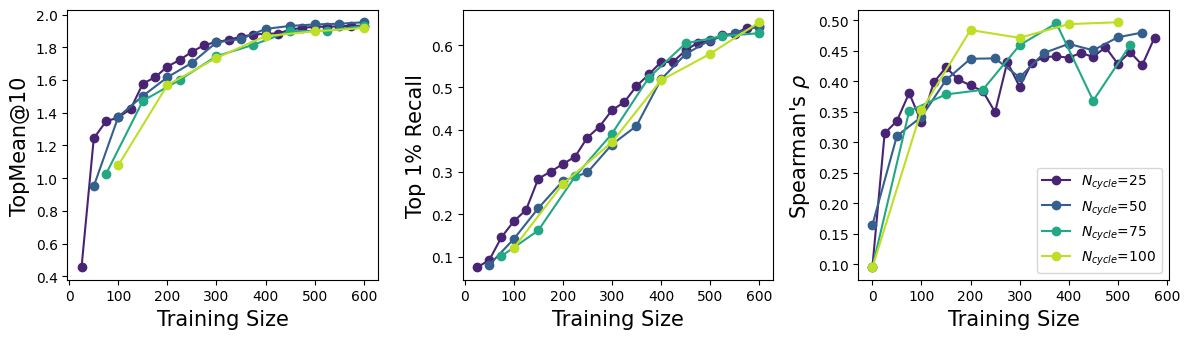

In [13]:
def plot_cycle_comparison(Xdf, metric, show_test=False, figsize=(12, 5), fontsize=15):
    Xdf_sel = Xdf[Xdf["tmp_path"].isin(configs_cycle_strat)]
    fig, axes = plt.subplots(1, len(model_types_l), figsize=figsize)
    colors = {
        25: plt.cm.viridis(0.1), 50: plt.cm.viridis(0.3), 75: plt.cm.viridis(0.6), 100: plt.cm.viridis(0.9)
    }
    # Get global min and max values for y-axis
    y_min = float('inf')
    y_max = float('-inf')
    for model_type in model_types_l:
        data = Xdf_sel[Xdf_sel["model_type"] == model_type]
        for N in [25, 50, 75, 100]:
            subset = data[data["N_per_cycle"] == N]
            mean_df = subset.groupby(["Training size"])[metric].mean()
            y_min = min(y_min, mean_df.min())
            y_max = max(y_max, mean_df.max())
    y_min = y_min - 0.05 * (y_max - y_min)
    y_max = y_max + 0.05 * (y_max - y_min)
    
    for ax_idx, model_type in enumerate(model_types_l):
        ax = axes[ax_idx]
        data = Xdf_sel[Xdf_sel["model_type"] == model_type]
        
        for N in [25, 50, 75, 100]:
            subset = data[data["N_per_cycle"] == N]
            # print(model_type, strategy, len(subset))
            mean_df = subset.groupby(["Training size"])[metric].mean()
            ax.plot(mean_df.index, mean_df, label=r"$N_{cycle}$="+str(N), marker="o", color=colors[N])
            
        ax.set_title(f"Model: {model_types.get(model_type, model_type)}", fontsize=fontsize)
        ax.set_xlabel("Training Size", fontsize=fontsize)
        ax.set_ylabel(metric_labels[metric], fontsize=fontsize)
        ax.set_ylim(y_min, y_max)  # Set same y-axis limits
        
        if ax_idx == len(axes)-1:
            if show_test:
                ax.plot([], [], color="gray", linestyle="--", label="Zeroshot")
            ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    
    plt.tight_layout()


def plot_cycle_comparison2(Xdf1, Xdf2, metrics, show_test=False, figsize=(12, 5), fontsize=15):
    Xdf_sel1 = Xdf1[Xdf1["tmp_path"].isin(configs_cycle_strat)]
    Xdf_sel2 = Xdf2[Xdf2["tmp_path"].isin(configs_cycle_strat)]
    model_type = "ablang2_gp"
    fig, axes = plt.subplots(1,3,figsize=figsize)
    colors = {
        25: plt.cm.viridis(0.1), 50: plt.cm.viridis(0.3), 75: plt.cm.viridis(0.6), 100: plt.cm.viridis(0.9)
    }
    # Get global min and max values for y-axis
    y_min = float('inf')
    y_max = float('-inf')
    for metric in metrics:
        Xdf_sel = Xdf_sel1 if metric in Xdf1.columns else Xdf_sel2
        data = Xdf_sel
        for N in [25, 50, 75, 100]:
            subset = data[data["N_per_cycle"] == N]
            mean_df = subset.groupby(["Training size"])[metric].mean()
            y_min = min(y_min, mean_df.min())
            y_max = max(y_max, mean_df.max())
    # y_min = y_min - 0.05 * (y_max - y_min)
    # y_max = y_max + 0.05 * (y_max - y_min)
    
    for ax_idx, metric in enumerate(metrics):
        Xdf_sel = Xdf_sel1 if metric in Xdf1.columns else Xdf_sel2
        data = Xdf_sel
        # ax = axes[ax_idx//2, ax_idx%2]
        ax = axes[ax_idx]
        for N in [25, 50, 75, 100]:
            subset = data[data["N_per_cycle"] == N]
            # print(model_type, strategy, len(subset))
            mean_df = subset.groupby(["Training size"])[metric].mean()
            ax.plot(mean_df.index, mean_df, label=r"$N_{cycle}$="+str(N), marker="o", color=colors[N])
            
        ax.set_xlabel("Training Size", fontsize=fontsize)
        ax.set_ylabel(metric_labels[metric], fontsize=fontsize)
    # ax.set_ylim(y_min, y_max)  # Set same y-axis limits
    # ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    ax.legend()
    
    plt.tight_layout()

noise_level=0
strategy="greedy"
configs_cycle_strat = []
for dms_index in range(TASKNUM):
    for N in [25, 50, 75, 100]:
        for model_type in ["sequence", "ablang2"]:
            tmp_path =  get_config_path(strategy, noise_level, dms_index, N, init_fold, model_type, use_dropout=strategy!="greedy")
            configs_cycle_strat.append(tmp_path)
        tmp_path =  get_config_ablang(path_ablang, 0, strategy, noise_level, dms_index, N, init_fold, kernel_type, add_kernel)
        configs_cycle_strat.append(tmp_path)
plot_cycle_comparison2(pool_metrics_df_merge, test_metrics_df_merge,  ["top_mean_1", "recall", "spearman"], show_test=False, figsize=(12, 3.5))
plt.tight_layout()


In [ ]:
fig, ax = plt.subplots(3,TASKNUM,figsize=(9,9))

for i in range(TASKNUM):
    df = pd.read_csv(f"outputs/greedy_0.0/dms_sequence_{i}_N-50_ini-1/predictions_cycle_11.csv")
    df_ablang = pd.read_csv(f"outputs/greedy_0.0/dms_ablang2_{i}_N-50_ini-1/predictions_cycle_11.csv")

    df_ab = pd.read_csv(f"outputs_ablang/0/greedy_0.0/dms_{i}_N-50_ini-1/predictions_cycle_11.csv")


    testdf = df[df["is_test"]]
    testdf_ablang = df_ablang[df_ablang["is_test"]]
    testdf_ab = df_ab[df_ab["is_test"]]

    score1 = spearmanr(testdf["DMS_score"], testdf["cycle_11_preds"]).statistic
    score2 = spearmanr(testdf_ablang["DMS_score"], testdf_ablang["cycle_11_preds"]).statistic
    score3 = spearmanr(testdf_ab["DMS_score"], testdf_ab["cycle_11_preds"]).statistic
    ax[0,i].scatter(testdf["DMS_score"], testdf["cycle_11_preds"], alpha=0.5, marker=".", label=f"$\\rho={score1:.2f}$")
    ax[1,i].scatter(testdf_ablang["DMS_score"], testdf_ablang["cycle_11_preds"], alpha=0.5, marker=".", label=f"$\\rho={score2:.2f}$")
    ax[2,i].scatter(testdf_ab["DMS_score"], testdf_ab["cycle_11_preds"], alpha=0.5, marker=".", label=f"$\\rho={score3:.2f}$")
    ax[0,i].legend(loc="lower right")
    ax[1,i].legend(loc="lower right")
    ax[2,i].legend(loc="lower right")
    ax[0,i].set_xlabel("DMS Score")
    ax[1,i].set_xlabel("DMS Score")
    ax[2,i].set_xlabel("DMS Score")

ax[0,0].set_title(idx2name[0])
ax[0,1].set_title(idx2name[1])
ax[0,2].set_title(idx2name[2])

ax[0,0].set_ylabel("ESM2\nPredicted Score")
ax[1,0].set_ylabel("ABlang2\nPredicted Score")
ax[2,0].set_ylabel("GPR(AbLang2)\nPredicted Score")
for i in range(1,TASKNUM):
    ax[0,i].set_ylabel("Predicted Score")
    ax[1,i].set_ylabel("Predicted Score")
    ax[2,i].set_ylabel("Predicted Score")

plt.tight_layout()
plt.tight_layout()
